# Метод сегментации Region Growing

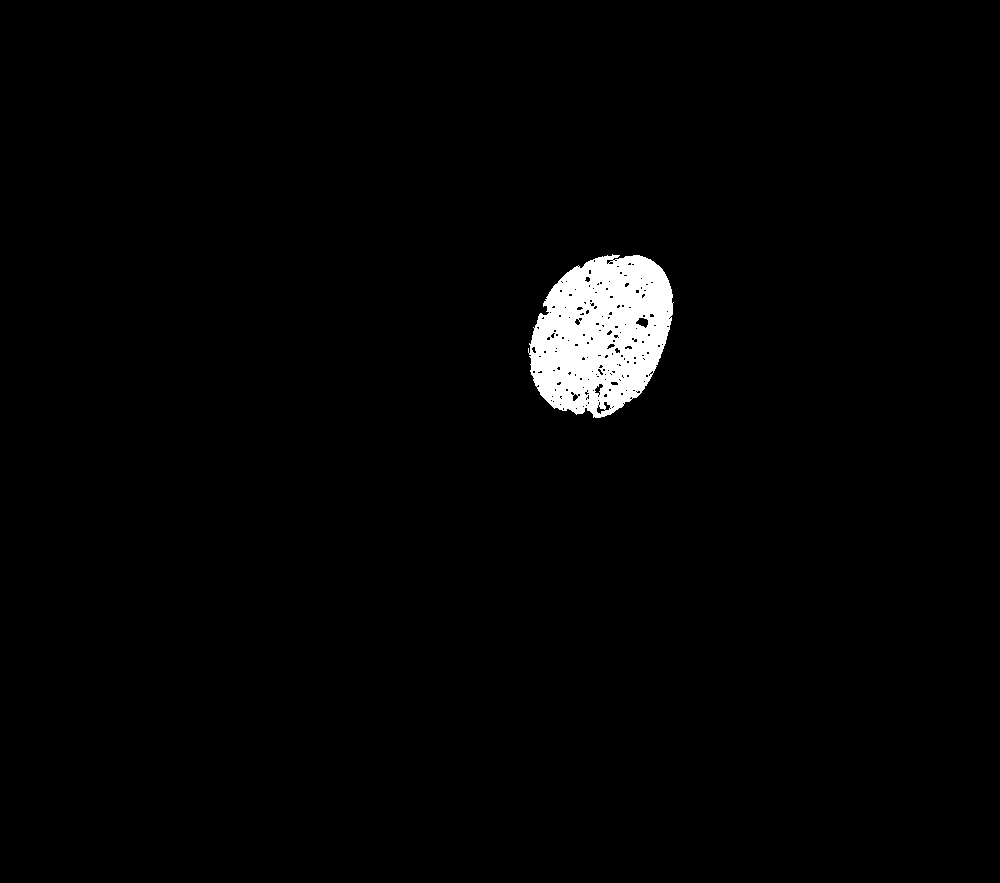

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display

def region_growing(image, seed_point, threshold):
    rows, cols = image.shape # Получаем размеры изображения
    segmented_image = np.zeros_like(image, dtype=np.uint8) # Создаем пустое бинарное изображение таких же размеров
    visited = np.zeros_like(image, dtype=bool) # Создаем массив для отметки посещенных пикселей (изначально все не посещены)
    seed_x, seed_y = seed_point # Распаковываем координаты начальной точки
    if not (0 <= seed_x < rows and 0 <= seed_y < cols): # Проверка на корректность начальной точки
        raise ValueError("Seed point is out of bounds.")
    queue = [(seed_x, seed_y)] # Инициализируем очередь с начальной точкой. Будем использовать очередь (FIFO) для обработки пикселей в порядке их обнаружения.
    visited[seed_x, seed_y] = True # Отмечаем начальную точку как посещенную
    segmented_image[seed_x, seed_y] = 255 # Добавляем начальную точку в сегментированную область
    while queue: # Цикл продолжается, пока очередь не пуста
        x, y = queue.pop(0) # Извлекаем координаты следующего пикселя из очереди
        for dx in [-1, 0, 1]: # Проходим по окрестности 3x3 (без центрального пикселя)
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0: # Пропускаем центральный пиксель
                    continue
                nx, ny = x + dx, y + dy # Координаты соседнего пикселя
                if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny]: # Проверка на выход за границы изображения и на то, был ли пиксель уже посещен
                    if abs(int(image[x, y]) - int(image[nx, ny])) <= threshold: # Проверяем условие сходства - разница интенсивностей меньше порогового значения?
                        queue.append((nx, ny)) # Добавляем подобный пиксель в очередь
                        visited[nx, ny] = True # Отмечаем его как посещенный
                        segmented_image[nx, ny] = 255 # Добавляем его в сегментированную область
    return segmented_image

# Загрузка изображения
image_path = "stones.png" # Замените на путь к вашему изображению
image_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image_original is None:
    print(f"Error: Could not load image from {image_path}")
    exit()
# Выбор начальной точки (x, y)
seed_point = (335, 598)
# Пороговое значение
threshold = 3
# Сегментация
segmented_image = region_growing(image_original, seed_point, threshold)
# Отображение результатов
cv2.imwrite('region_growing_result.jpg', segmented_image)
display(Image('region_growing_result.jpg'))



Задание

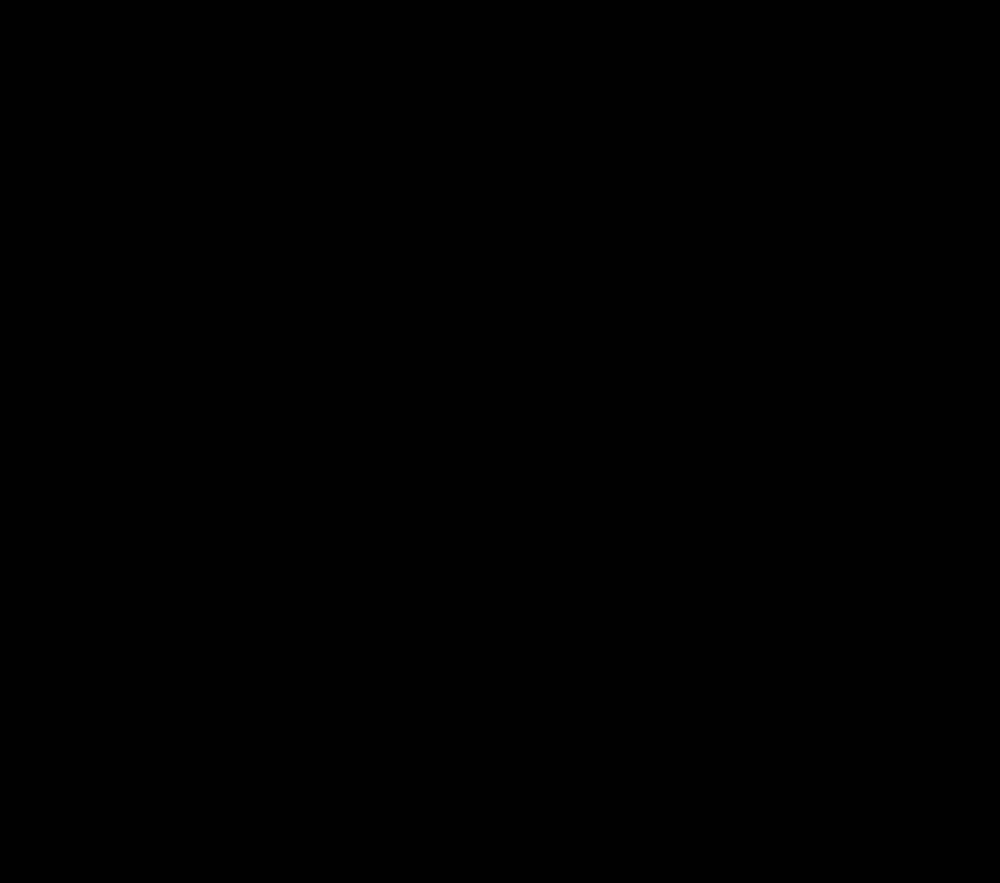

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display
from collections import deque

def region_growing(image, seed_point, threshold):
    h, w = image.shape
    segmented = np.zeros((h, w), dtype=np.uint8)
    visited = np.zeros((h, w), dtype=np.uint8)

    # Проверяем, что начальная точка внутри изображения
    x, y = seed_point
    if x < 0 or y < 0 or x >= w or y >= h:
        return segmented

    # Среднее значение региона
    region_mean = float(image[y, x])
    region_size = 1

    # Очередь для обработки пикселей
    queue = deque()
    queue.append((x, y))
    segmented[y, x] = 255
    visited[y, x] = 1

    # 8-связность соседей
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 (0, -1),          (0, 1),
                 (1, -1),  (1, 0), (1, 1)]

    while queue:
        x, y = queue.popleft()

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy

            # Проверяем, что сосед внутри изображения и не посещен
            if nx >= 0 and ny >= 0 and nx < w and ny < h and not visited[ny, nx]:
                pixel_value = image[ny, nx]
                # Проверяем условие сходства
                if abs(pixel_value - region_mean) <= threshold:
                    segmented[ny, nx] = 255
                    visited[ny, nx] = 1
                    queue.append((nx, ny))
                    # Обновляем среднее значение региона
                    region_mean = (region_mean * region_size + pixel_value) / (region_size + 1)
                    region_size += 1

    return segmented

# Загрузка и обработка изображения
image_path = "stones.png"
image_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image_original is None:
    print(f"Error: Could not load image from {image_path}")
    exit()

# Параметры
seed_point = (335, 598)  # (x, y)
threshold = 3

# Сегментация
segmented_image = region_growing(image_original, seed_point, threshold)

# Используем inRange для создания маски (хотя segmented уже бинарное изображение)
# Это пример, как можно использовать inRange для постобработки
mask = cv2.inRange(segmented_image, 10, 150)

# Сохранение и отображение
cv2.imwrite('region_growing_result.jpg', mask)
display(Image('region_growing_result.jpg'))

# Метод сегментации изображений Split-and-Merge


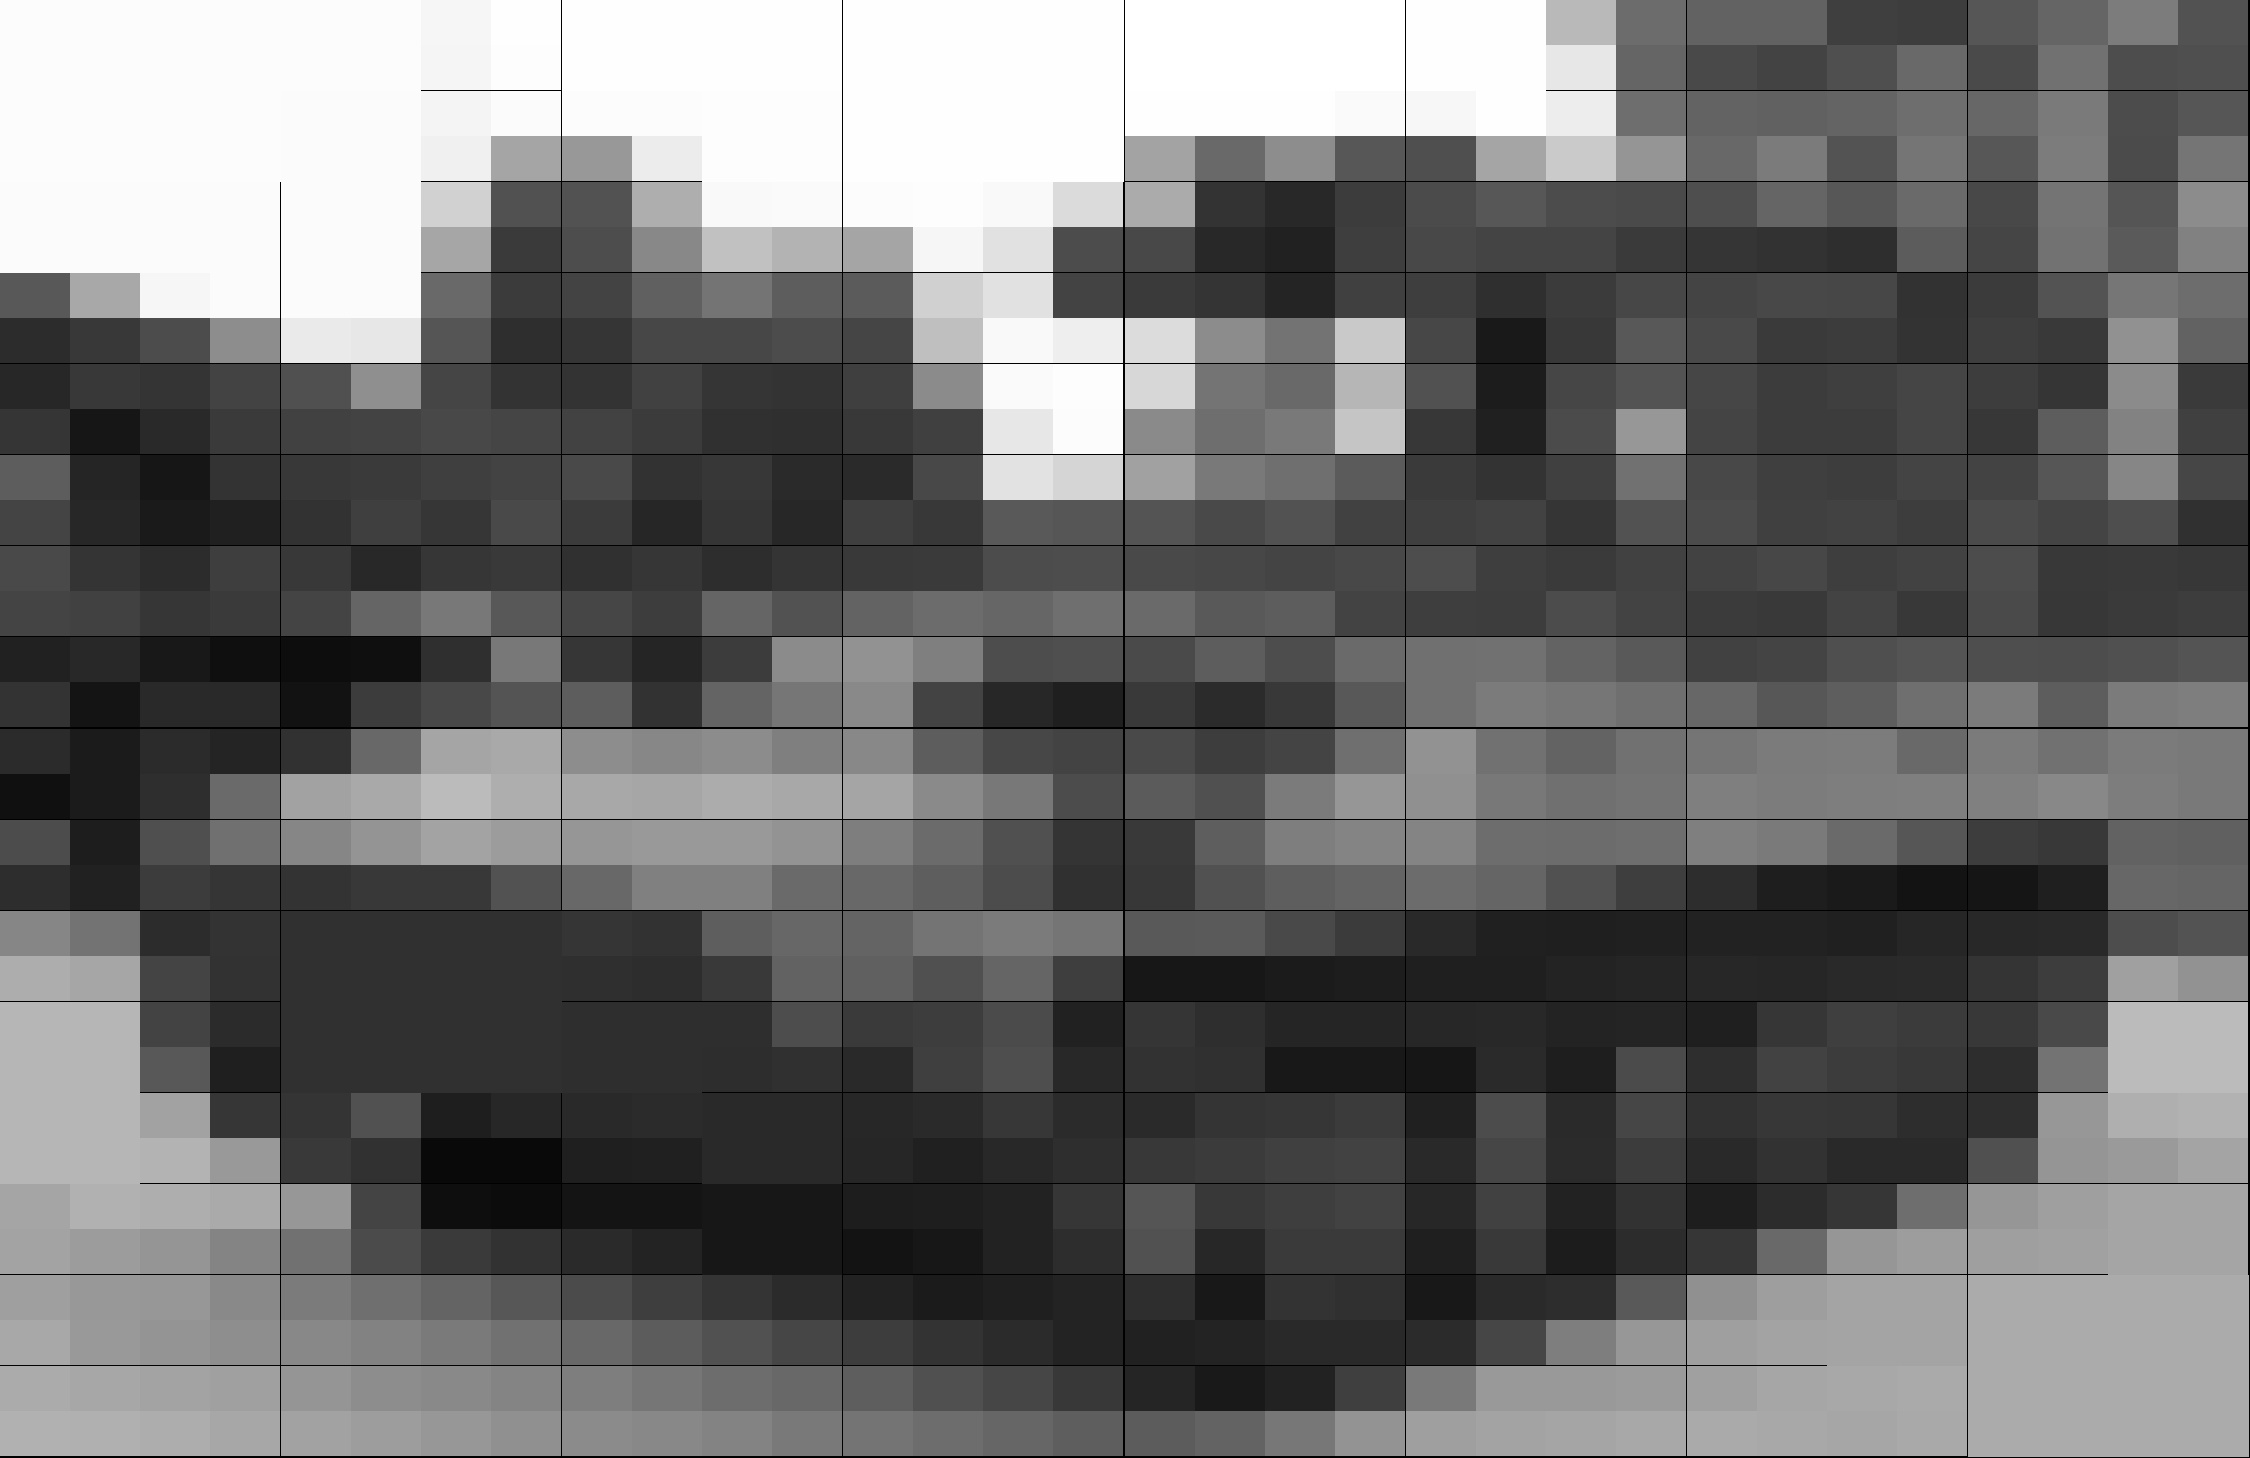

In [ ]:
# Метод сегментации изображений Split-and-Merge
import cv2
import numpy as np

def split_and_merge(image, min_size, homogeneity_threshold):
    rows, cols = image.shape
    segmented_image = np.zeros_like(image, dtype=np.uint8)
    def process_region(x, y, width, height, region_image):
        """Рекурсивно обрабатывает регион изображения."""
        region_mean = np.mean(region_image)
        region_std = np.std(region_image)
        if width <= min_size or height <= min_size or region_std <= homogeneity_threshold:
            # Условие остановки: регион достаточно мал или однороден
            segmented_image[y:y+height, x:x+width] = region_mean # Заполняем регион средним значением
        else:
            # Разделение региона на 4 подрегиона
            half_width = width // 2
            half_height = height // 2
            process_region(x, y, half_width, half_height, region_image[:half_height, :half_width])          #Верхний левый
            process_region(x + half_width, y, half_width, half_height, region_image[:half_height, half_width:]) #Верхний правый
            process_region(x, y + half_height, half_width, half_height, region_image[half_height:, :half_width])#Нижний левый
            process_region(x + half_width, y + half_height, half_width, half_height, region_image[half_height:, half_width:]) #Нижний правый
    # Начало рекурсивного процесса со всего изображения
    process_region(0, 0, cols, rows, image)
    return segmented_image

# Пример использования:
image_path = "arrow-10.jpg"
image_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image_original is None:
    print(f"Error: Could not load image from {image_path}")
    exit()
min_region_size = 80 # Минимальный размер региона
homogeneity_threshold = 10 #Порог однородности
segmented_image = split_and_merge(image_original, min_region_size, homogeneity_threshold)
# Отображение результатов
cv2.imwrite('split_and_merge.jpg', segmented_image)
display(Image('split_and_merge.jpg'))


Задание


Эксперимент 1: min_size=80, threshold=10


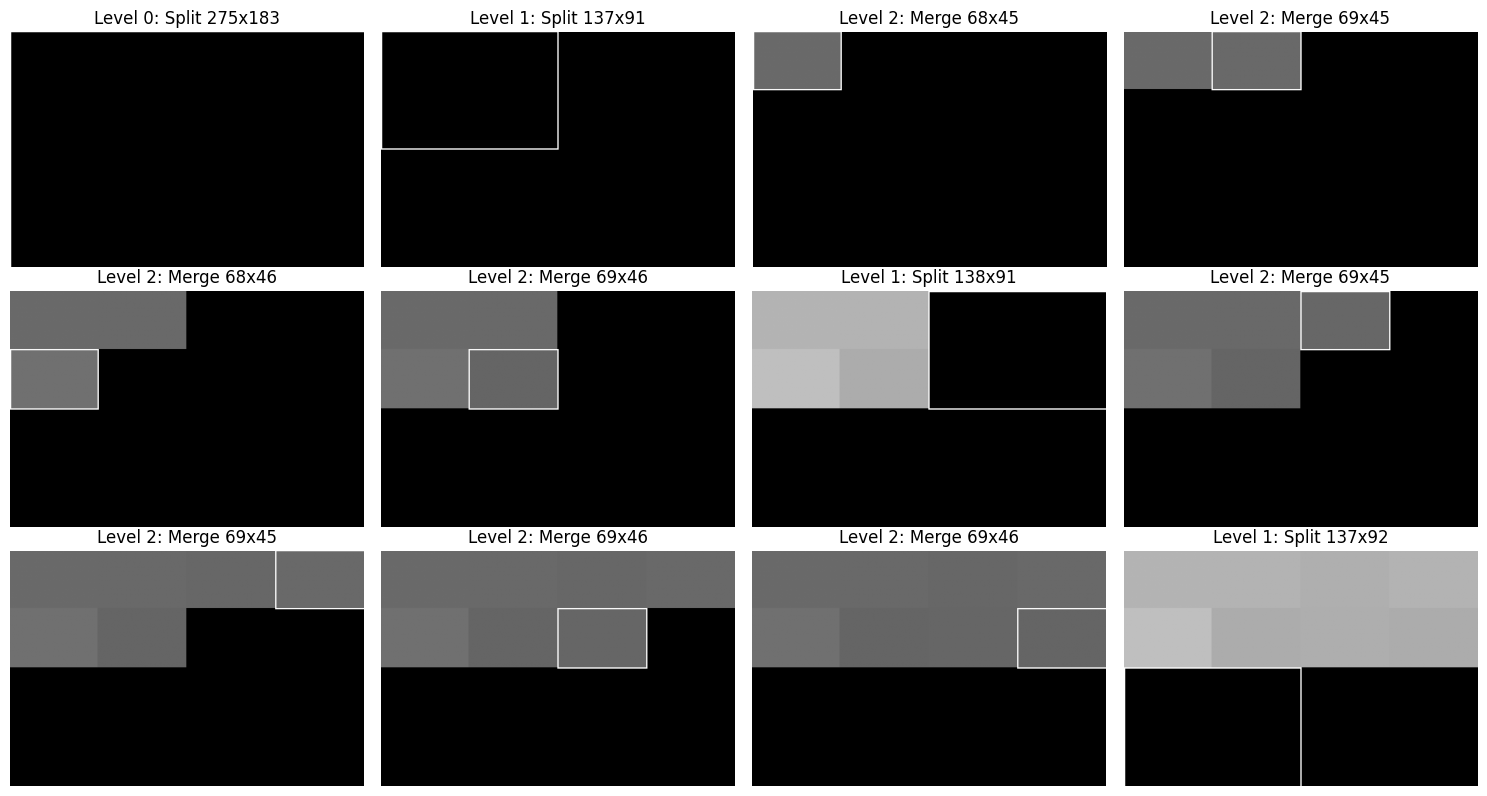

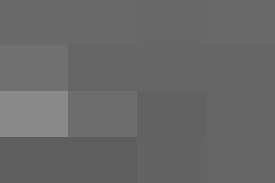


Эксперимент 2: min_size=40, threshold=20


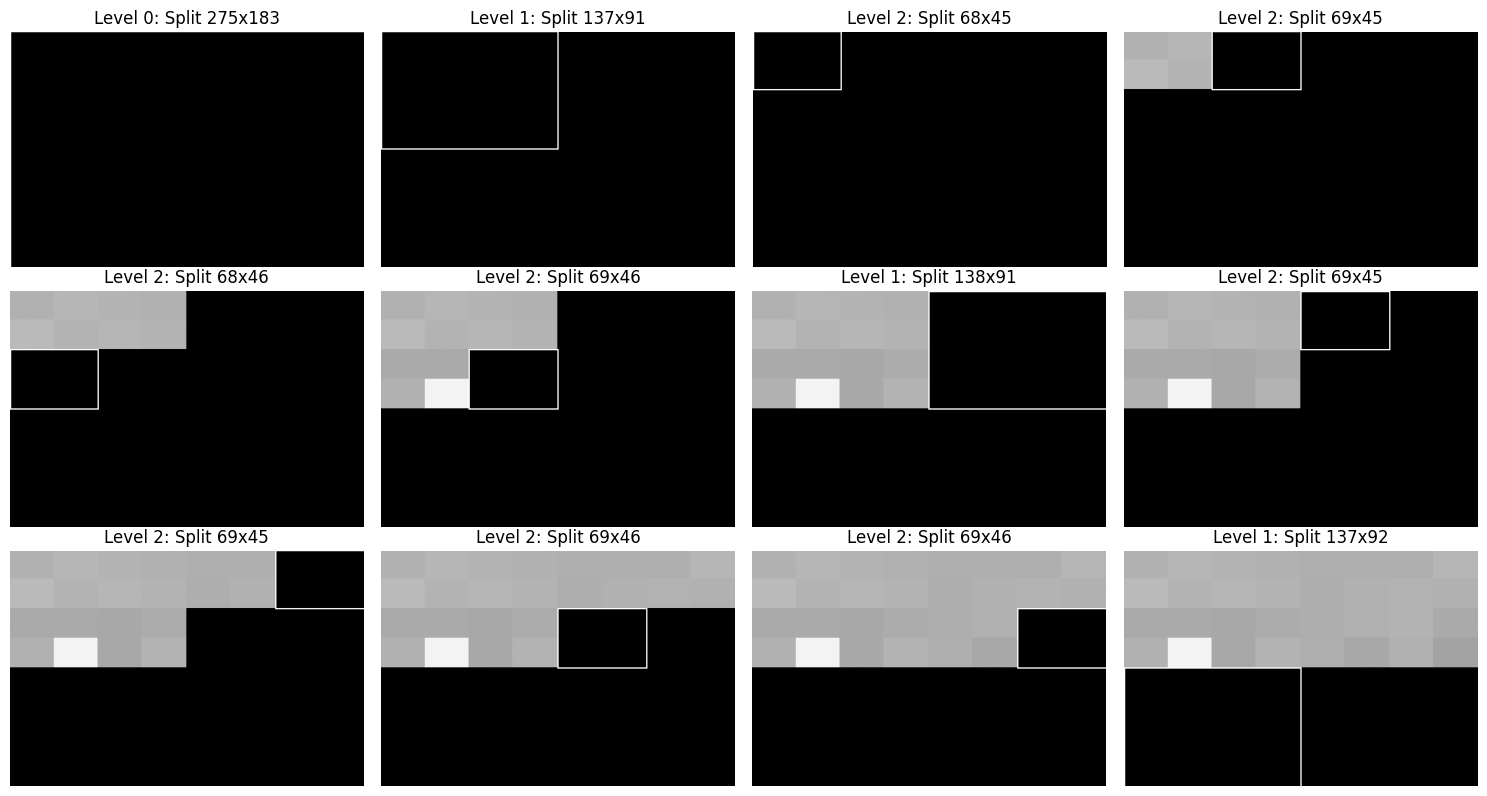

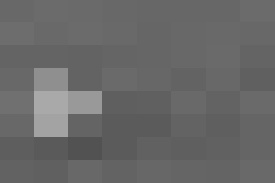


Эксперимент 3: min_size=20, threshold=5


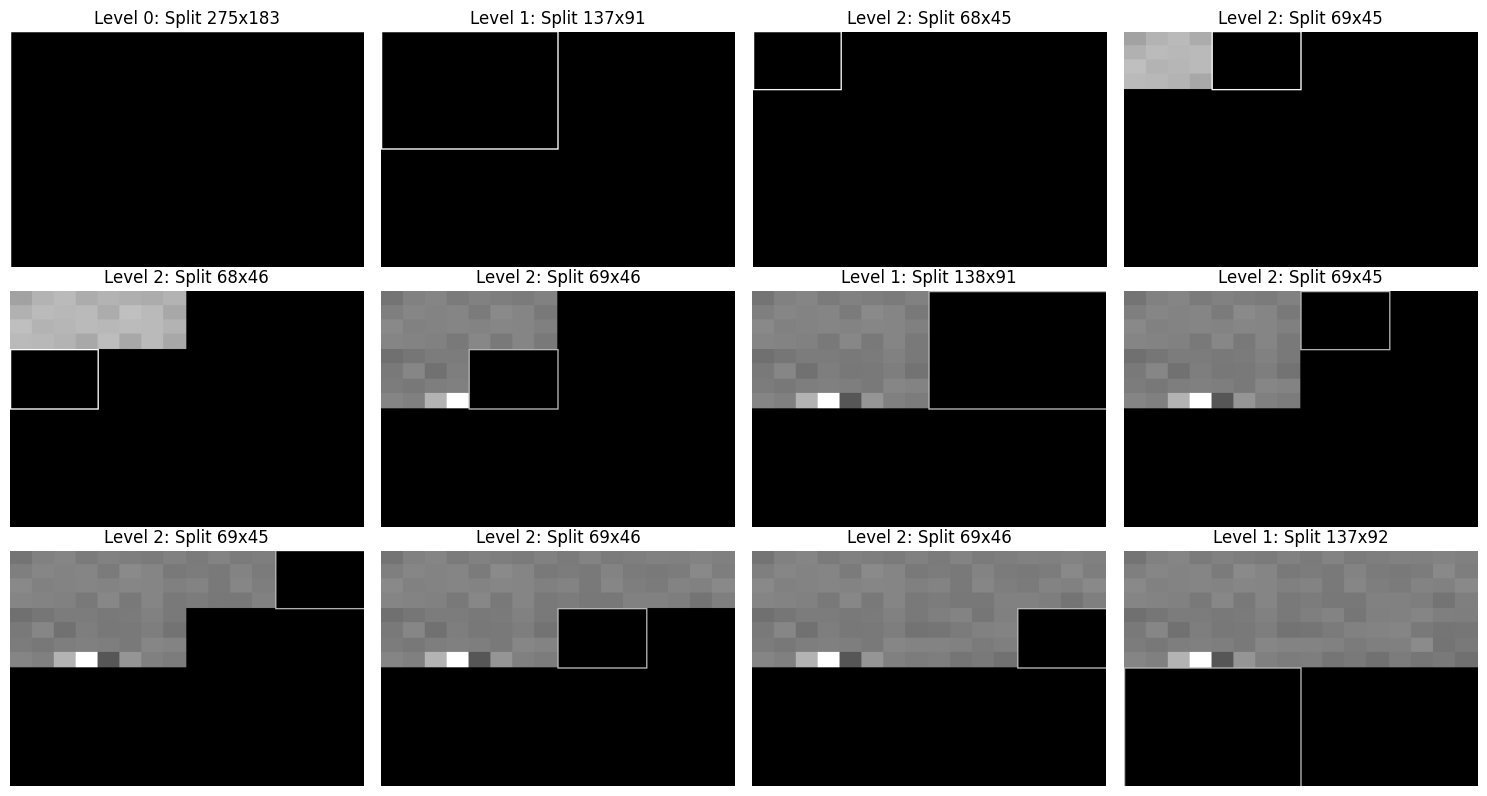

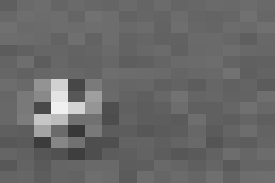


Эксперимент 4: min_size=10, threshold=2


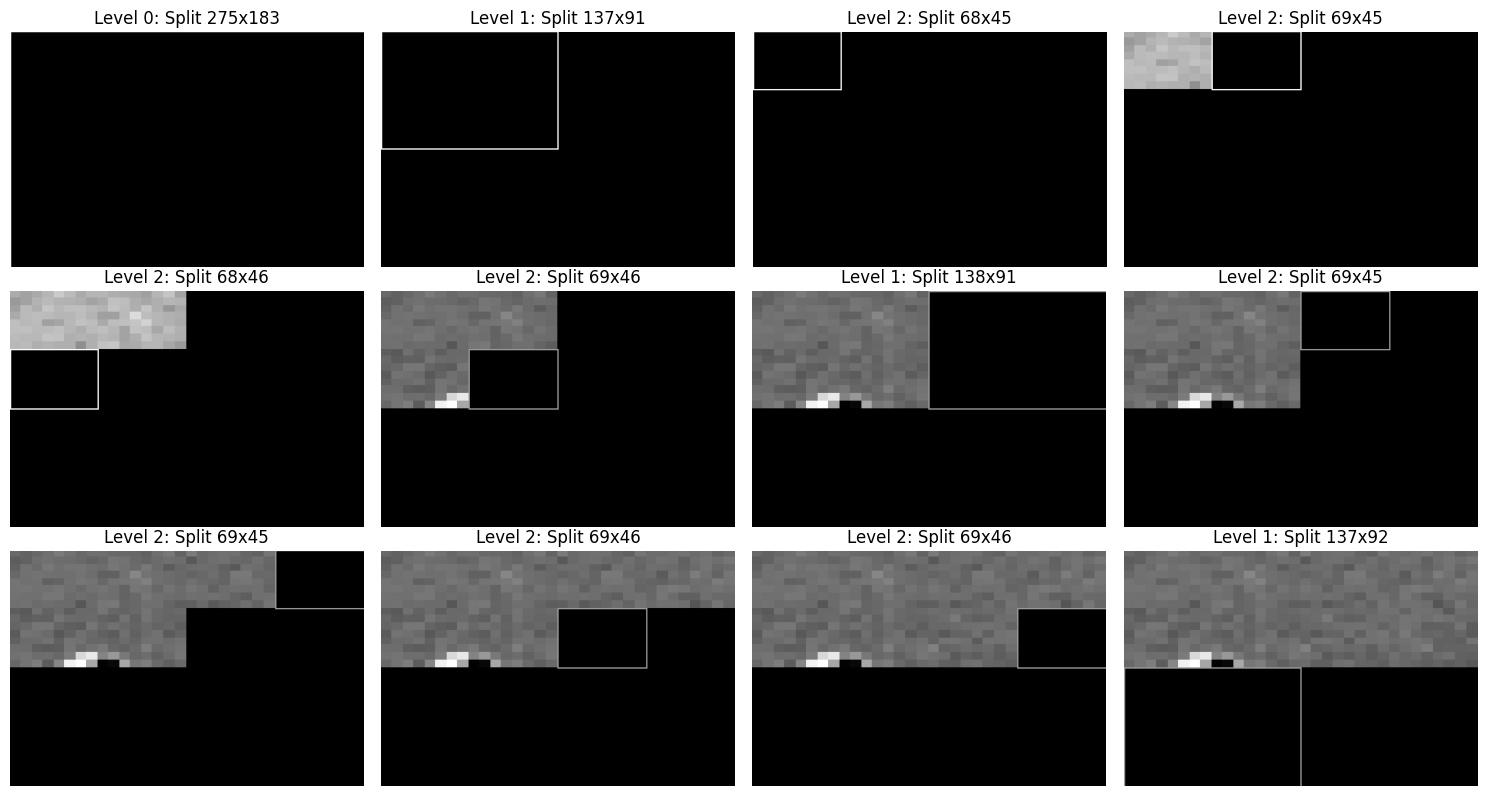

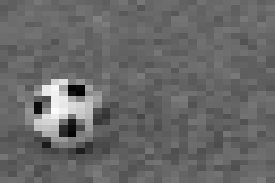

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt

def split_and_merge(image, min_size, homogeneity_threshold, visualize=False):
    rows, cols = image.shape
    segmented_image = np.zeros_like(image, dtype=np.uint8)
    visualization = []  # Для хранения промежуточных результатов

    def process_region(x, y, width, height, region_image, level=0):
        nonlocal visualization

        region_mean = np.mean(region_image)
        region_std = np.std(region_image)

        if width <= min_size or height <= min_size or region_std <= homogeneity_threshold:
            segmented_image[y:y+height, x:x+width] = region_mean

            if visualize and level < 3:  # Ограничиваем глубину визуализации
                viz = segmented_image.copy()
                cv2.rectangle(viz, (x,y), (x+width,y+height), (255,255,255), 1)
                visualization.append((viz, f"Level {level}: Merge {width}x{height}"))
        else:
            half_width = width // 2
            half_height = height // 2

            if visualize and level < 3:
                viz = segmented_image.copy()
                cv2.rectangle(viz, (x,y), (x+width,y+height), (150,150,150), 1)
                visualization.append((viz, f"Level {level}: Split {width}x{height}"))

            # Рекурсивная обработка 4 подрегионов
            process_region(x, y, half_width, half_height,
                          region_image[:half_height, :half_width], level+1)
            process_region(x + half_width, y, width - half_width, half_height,
                          region_image[:half_height, half_width:], level+1)
            process_region(x, y + half_height, half_width, height - half_height,
                          region_image[half_height:, :half_width], level+1)
            process_region(x + half_width, y + half_height,
                          width - half_width, height - half_height,
                          region_image[half_height:, half_width:], level+1)

    process_region(0, 0, cols, rows, image)

    if visualize:
        plt.figure(figsize=(15, 8))
        for i, (img, title) in enumerate(visualization[:12]):  # Показываем первые 12 шагов
            plt.subplot(3, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return segmented_image

# Загрузка изображения
image_path = "ball.jpg"
image_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image_original is None:
    print(f"Error: Could not load image from {image_path}")
    exit()

# Параметры для экспериментов
params = [
    {'min_size': 80, 'threshold': 10},   # Большие регионы, низкая чувствительность
    {'min_size': 40, 'threshold': 20},   # Средние регионы, средняя чувствительность
    {'min_size': 20, 'threshold': 5},    # Маленькие регионы, высокая чувствительность
    {'min_size': 10, 'threshold': 2}     # Очень мелкие регионы
]

# Проведение экспериментов
for i, param in enumerate(params):
    print(f"\nЭксперимент {i+1}: min_size={param['min_size']}, threshold={param['threshold']}")

    segmented = split_and_merge(image_original.copy(),
                              param['min_size'],
                              param['threshold'],
                              visualize=True)

    cv2.imwrite(f'split_merge_exp_{i+1}.jpg', segmented)
    display(Image(f'split_merge_exp_{i+1}.jpg'))